<a href="https://colab.research.google.com/github/Sestiano/Semantic-Analysis-of-Texts-Generated-with-Mistral-AI/blob/main/Hakan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Semantic Analysis of Texts Generated with Mistral AI

This notebook contains the analysis of texts generated using the Mistral AI model with different temperatures and prompts. The objective is to study how the characteristics of semantic networks change as the generation temperature and prompt type (complex vs vague) vary.

Fundamental principles of the analysis:
- Generation of texts with controlled parameters
- Creation of semantic networks using two approaches: co-occurrence and EmoAtlas
- Metric analysis of the generated semantic networks
- Visualization of results and comparative analysis

## Text Generation with Mistral AI

Configuration of parameters for text generation using the Mistral API. Texts will be generated using different temperatures and two types of prompts (complex and vague).

In [ ]:
!pip install mistralai # Comment this line if you are not running on Google Colab

In [3]:
from mistralai import Mistral
import os
from tqdm import tqdm

In [ ]:
# ================== CONFIGURATION ==================

API_KEY = "insert_your_API_KEY_here"
MODEL = "mistral-small-latest"
TEMPERATURES = [0.001, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5]

N_COMPLETIONS = 5

SYSTEM_INSTRUCTION = (
    """ Please read the following prompt carefully and adopt the perspective of a writer.
    Your task is to continue the story in any direction you choose.
    The story should be between 250 and 350 words. """
)

PROMPTS = {
    "prompt_complex": (
        """ Cameron opened the door and slid inside, slowly. Her dull, colourless room welcomed
        her, looking back at her pointlessly. She sighed profoundly, throwing her bag in
        the corner. Another slow, painfully slow evening was waiting for her. She took a
        shower, trying to shake a crawling feeling of emptiness away from her body. She
        ate without any pleasure and stared blankly at the tv for some time, and ended up
        falling asleep the second her head touched the pillow. The morning after, she
        opened her eyes, already surrendered to the doom of her everyday life; but to her
        great surprise, she found herself """
    ),
    "prompt_vague": (
        """Cameron, after that very stressful day, fell asleep in her bed as usual.
        The next day she opened her eyes and, to her great surprise, found herself
        """
        # you can add more prompts here
    ),
}

client = Mistral(api_key=API_KEY)

# Calculate the total number of operations for the progress bar
total_operations = len(PROMPTS) * len(TEMPERATURES)
print(f"Starting generation of {total_operations} text sets...")

# Create main texts directory
texts_dir = "texts"
os.makedirs(texts_dir, exist_ok=True)

# Unified progress bar
with tqdm(total=total_operations, desc="Generating texts") as pbar:
    for prompt_name, prompt_text in PROMPTS.items():
        # Create directory with the prompt name inside texts folder
        out_dir = os.path.join(texts_dir, f"mistral_{prompt_name}")
        os.makedirs(out_dir, exist_ok=True)

        for temp in TEMPERATURES:
            # Update progress bar description
            pbar.set_description(f"Processing {prompt_name} T={temp}")
            
            completions = []
            n = N_COMPLETIONS
            
            # Generate completions for this prompt-temperature combination
            while len(completions) < n:
                batch_size = min(10, n - len(completions))

                response = client.chat.complete(
                    model=MODEL,
                    messages=[
                        {"role": "system", "content": SYSTEM_INSTRUCTION},
                        {"role": "user", "content": prompt_text},
                    ],
                    temperature=temp,
                    n=batch_size,
                )

                batch = [choice.message.content.strip() for choice in response.choices]
                completions.extend(batch)

            # Write texts to file separated by two blank lines
            file_path = os.path.join(out_dir, f"{prompt_name}_{temp}.txt")
            with open(file_path, "w", encoding="utf-8") as f:
                f.write("\n\n".join(completions))
            
            # Update progress bar
            pbar.update(1)

print(f"\nGeneration completed!")
print(f"  - Processed prompts: {len(PROMPTS)}")
print(f"  - Temperatures per prompt: {len(TEMPERATURES)}")
print(f"  - Completions per temperature: {N_COMPLETIONS}")
print(f"  - Total texts generated: {len(PROMPTS) * len(TEMPERATURES) * N_COMPLETIONS}")

Starting generation of 14 text sets...


Processing prompt_vague T=1.5: 100%|██████████| 14/14 [00:49<00:00,  3.57s/it]   


✓ Generation completed!
  - Processed prompts: 2
  - Temperatures per prompt: 7
  - Completions per temperature: 5
  - Total texts generated: 70


## Cleaning of Generated Texts

The following code is responsible for cleaning the generated texts by removing:
- Punctuation
- Stop words
- Numbers
- Special characters

We use Spacy for advanced linguistic processing, which allows for more sophisticated analysis compared to simple regular expressions.

In [ ]:
!pip install spacy glob2 # Comment this line if you are not running on Google Colab
!python -m spacy download en_core_web_lg # We use en_core_web_lg to clean the text

In [2]:
import spacy
import glob
import string

In [ ]:
def clean_and_export_with_spacy(raw_text: str, lang_model: str = 'en_core_web_lg') -> str:
    """
    Cleans a text using Spacy by removing punctuation, stop words, and numbers.

    Args:
        raw_text: the text to clean
        lang_model: the linguistic model to use (default: en_core_web_lg)

    Returns:
        the cleaned text with one line per sentence
    """
    # Normalize newline characters
    raw_text = raw_text.replace("\\n", "\n")

    # Load the linguistic model
    nlp = spacy.load(lang_model)

    # Process the text with Spacy
    doc = nlp(raw_text)

    # Process each sentence separately
    cleaned_lines = []
    for sent in doc.sents:
        # Extract only relevant tokens and remove special characters
        tokens = [
            tok.text.lower().translate(str.maketrans('', '', string.punctuation))
            for tok in sent
            if not tok.is_space      # remove spaces
            and not tok.is_stop      # remove stop words
            and not tok.is_punct     # remove punctuation
            and not tok.like_num     # remove numbers
        ]

        # Join tokens in a line
        line = " ".join(t for t in tokens if t)
        if line:  # add only non-empty lines
            cleaned_lines.append(line)

    # Return the cleaned text
    return "\n".join(cleaned_lines)

if __name__ == '__main__':
    # Define base directories
    texts_dir = "texts"
    
    # Create cleaned directories directly in texts folder
    cleaned_dirs = {
        "complex": os.path.join(texts_dir, "cleaned_mistral_complex"),
        "vague": os.path.join(texts_dir, "cleaned_mistral_vague")
    }
    
    # Create cleaned directories
    for cleaned_dir in cleaned_dirs.values():
        os.makedirs(cleaned_dir, exist_ok=True)
    
    # Find all text files in the texts directory
    search_pattern = os.path.join(texts_dir, "mistral_prompt_*", "*.txt")
    all_files = glob.glob(search_pattern)
    
    # Filter files to process
    files_to_process = [
        path for path in all_files
        if not (path.endswith('_cleaned.txt') or
                'emo_edges_' in path or 'edges_' in path)
    ]
    
    print(f"Found {len(files_to_process)} files to clean...")
    
    # Process files with progress bar
    with tqdm(total=len(files_to_process), desc="Cleaning texts") as pbar:
        for path in files_to_process:
            # Update progress bar description
            filename = os.path.basename(path)
            pbar.set_description(f"Cleaning {filename}")
            
            # Read the content of the original file
            with open(path, 'r', encoding='utf-8') as f:
                raw = f.read()

            # Apply text cleaning
            cleaned = clean_and_export_with_spacy(raw)

            # Determine output directory based on source
            if 'mistral_prompt_complex' in path:
                out_dir = cleaned_dirs["complex"]
            elif 'mistral_prompt_vague' in path:
                out_dir = cleaned_dirs["vague"]
            else:
                pbar.update(1)
                continue  # Skip if not matching expected pattern

            # Save the cleaned text in the appropriate cleaned directory
            out_path = os.path.join(out_dir, f"{os.path.splitext(filename)[0]}_cleaned.txt")
            with open(out_path, 'w', encoding='utf-8') as f:
                f.write(cleaned)

            # Update progress bar
            pbar.update(1)

    print(f"\nText cleaning completed!")
    print(f"  - Files processed: {len(files_to_process)}")
    print(f"  - Cleaned files saved in: {list(cleaned_dirs.values())}")

Found 14 files to clean...


Cleaning prompt_vague_1.5.txt: 100%|██████████| 14/14 [00:57<00:00,  4.09s/it]   


✓ Text cleaning completed!
  - Files processed: 14
  - Cleaned files saved in: ['texts/cleaned_mistral_complex', 'texts/cleaned_mistral_vague']


## Imports for Emotional Network Analysis

In this section, we import specific libraries for emotional network analysis, in particular:
- `nltk` for natural language processing
- `emoatlas` for building emotional semantic networks
- `pathlib` for managing file paths in a more modern way

In [ ]:
!pip install nltk # Comment this line if you are not running on Google Colab
!pip install git+https://github.com/MassimoStel/emoatlas # Comment this line if you are not running on Google Colab

In [5]:
import nltk
from emoatlas import EmoScores
import emoatlas as emos
from pathlib import Path

## Creation of Emotional Networks with EmoAtlas

In this section we use the EmoAtlas library to build emotional semantic networks from the generated texts. Unlike the co-occurrence approach, EmoAtlas creates connections based on emotional relationships between words.

The process includes:
1. Loading raw texts (not cleaned)
2. Building a FormaMentis network for each text
3. Exporting edge lists into separate files

In [6]:
# Creation of edge lists with EmoAtlas (from original texts)

nltk.download('wordnet')

emos = EmoScores()

# Update paths to work with new directory structure
dirs = [
    os.path.join('texts', 'mistral_prompt_complex'),  # updated path
    os.path.join('texts', 'mistral_prompt_vague'),    # updated path
]

# Count total files for progress bar
total_files = 0
for in_dir in dirs:
    if os.path.exists(in_dir):
        pattern = os.path.join(in_dir, '*.txt')
        files = [f for f in glob.glob(pattern) if not f.endswith('_cleaned.txt')]
        total_files += len(files)

print(f"Found {total_files} files to process with EmoAtlas...")

# Process files with progress bar
with tqdm(total=total_files, desc="Creating emotional networks") as pbar:
    for in_dir in dirs:
        if not os.path.exists(in_dir):
            print(f"Warning: Directory {in_dir} not found")
            continue
            
        # Extract the prompt type: 'complex' or 'vague'
        prompt_type = in_dir.split('_')[-1]
        # Create the output directory for emotional edge lists
        out_dir = f'emo_edges_{prompt_type}'
        os.makedirs(out_dir, exist_ok=True)

        # Process each original text file (exclude those already cleaned)
        pattern = os.path.join(in_dir, '*.txt')
        for path in glob.glob(pattern):
            filename = os.path.basename(path)
            # Skip already cleaned files
            if filename.endswith('_cleaned.txt'):
                continue

            # Update progress bar description
            pbar.set_description(f"Processing {filename}")

            # Extract the temperature value from the filename: prompt_[type]_[temperature].txt
            base = os.path.splitext(filename)[0]
            parts = base.split('_')
            if len(parts) >= 2:
                temp = parts[-1]  # the last part is the temperature value
            else:
                print(f"Skip {filename}: unable to extract temperature")
                pbar.update(1)
                continue

            # Read the original text
            try:
                with open(path, 'r', encoding='utf-8') as f:
                    text = f.read()

                # Building the emotional network using EmoAtlas
                try:
                    # FormaMentis creates a semantic network based on emotional relationships
                    network = emos.formamentis_network(text)

                    # Verify that the network actually contains edges
                    if not hasattr(network, 'edges') or not network.edges:
                        print(f"Warning: No edges created for {filename}")
                        pbar.update(1)
                        continue

                    # Export the edge list
                    out_path = os.path.join(out_dir, f'emo_edge_list_{prompt_type}_{temp}.txt')
                    with open(out_path, 'w', encoding='utf-8') as outf:
                        for u, v in network.edges:
                            outf.write(f"{u}\t{v}\n")

                    # Update progress bar
                    pbar.update(1)

                except Exception as e:
                    print(f"Error in network generation for {filename}: {str(e)}")
                    pbar.update(1)

            except Exception as e:
                print(f"Error in reading {path}: {str(e)}")
                pbar.update(1)

print(f"\nEmoAtlas network creation completed!")
print(f"  - Edge lists saved in: emo_edges_complex/ and emo_edges_vague/")

[nltk_data] Downloading package wordnet to /home/seb/nltk_data...


Found 14 files to process with EmoAtlas...


Processing prompt_vague_1.5.txt: 100%|██████████| 14/14 [02:51<00:00, 12.24s/it]   


EmoAtlas network creation completed!
  - Edge lists saved in: emo_edges_complex/ and emo_edges_vague/


## Semantic Network Analysis

In this section, we analyze the generated semantic networks, calculating important metrics such as:
- Number of nodes and edges
- Network density
- Clustering coefficient
- Average path length
- Average and maximum node degree

The results will be visualized in graphs and saved in a CSV file for subsequent analysis.

In [10]:
import pandas as pd
from tabulate import tabulate
import matplotlib.pyplot as plt
import re
import numpy as np
import logging 
import networkx as nx

def extract_temperature(id_string):
    """Extracts the temperature value from the file name."""
    match = re.search(r'_(\d+(?:\.\d+)?)(?:_cleaned)?', id_string)
    return float(match.group(1)) if match else None

In [23]:
# Edge-list Analysis

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def analyze_edge_list(file_path):
    """
    Analyzes an edge-list file and calculates the network metrics.
    """
    try:
        # Loading edges and building the graph in a single pass
        G = nx.Graph()
        
        with open(file_path, "r", encoding="utf-8") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 2:
                    G.add_edge(parts[0], parts[1])

        # Calculating network metrics
        n = G.number_of_nodes()
        m = G.number_of_edges()

        # Safe calculation of metrics
        density = (2 * m) / (n * (n - 1)) if n > 1 else 0
        avg_clustering = nx.average_clustering(G) if n > 0 else 0

        # Calculating average path length (only if graph is connected)
        path_len = float('nan')
        if nx.is_connected(G) and n > 1:
            try:
                path_len = nx.average_shortest_path_length(G)
            except Exception as e:
                print(f"Warning: Could not calculate path length for {os.path.basename(file_path)}: {e}")

        # Degree-based metrics
        degrees = [d for _, d in G.degree()]
        avg_degree = sum(degrees) / n if n > 0 else 0
        max_degree = max(degrees) if degrees else 0
        std_degree = np.std(degrees) if degrees else 0
        diameter = nx.diameter(G) if nx.is_connected(G) and n > 1 else float('nan')
        transitivity = nx.transitivity(G) if n > 0 else 0

        # Simplified: only determine prompt type (method is always EmoAtlas)
        lower = file_path.lower()
        prompt_type = ('complex' if 'complex' in lower else
                      'vague' if 'vague' in lower else 'other')

        file_name = os.path.splitext(os.path.basename(file_path))[0]
        temp_match = re.search(r'_(\d+(?:\.\d+)?)$', file_name)
        temperature = float(temp_match.group(1)) if temp_match else np.nan

        return {
            'id': file_name,
            'prompt_type': prompt_type,
            'temperature': temperature,
            'nodes': n,
            'edges': m,
            'density': density,
            'clustering': avg_clustering,
            'path_len': path_len,
            'avg_deg': avg_degree,
            'max_deg': max_degree,
            'std_deg': std_degree,
            'diameter': diameter,
            'transitivity': transitivity,
            'file_path': file_path
        }

    except Exception as e:
        print(f"Error analyzing {file_path}: {e}")
        return None

def create_visualizations(df):
    """
    Creates optimized visualizations for EmoAtlas network analysis.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    from pathlib import Path
    import numpy as np
    
    # Create output directory
    out_dir = Path('visualizations')
    out_dir.mkdir(exist_ok=True)
    
    # Set clean style
    plt.style.use('seaborn-v0_8')
    colors = {'complex': '#1f77b4', 'vague': '#ff7f0e'}
    
    # Single overview plot for EmoAtlas
    print("Creating EmoAtlas overview plots...")
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle('EmoAtlas Network Analysis', fontsize=16, fontweight='bold')
    
    # Plot 1: Temperature vs Density
    ax = axes[0, 0]
    for prompt_type in ['complex', 'vague']:
        sub = df[df['prompt_type'] == prompt_type]
        if sub.empty:
            continue
        sub = sub.sort_values('temperature')
        ax.plot(sub['temperature'], sub['density'], 
               marker='o', linewidth=2, markersize=6, 
               color=colors[prompt_type], label=prompt_type.capitalize())
    
    ax.set_xlabel('Temperature')
    ax.set_ylabel('Density')
    ax.set_title('Temperature vs Density')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 2: Temperature vs Clustering
    ax = axes[0, 1]
    for prompt_type in ['complex', 'vague']:
        sub = df[df['prompt_type'] == prompt_type]
        if sub.empty:
            continue
        sub = sub.sort_values('temperature')
        ax.plot(sub['temperature'], sub['clustering'], 
               marker='s', linewidth=2, markersize=6, 
               color=colors[prompt_type], label=prompt_type.capitalize())
    
    ax.set_xlabel('Temperature')
    ax.set_ylabel('Clustering Coefficient')
    ax.set_title('Temperature vs Clustering')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 3: Nodes vs Edges
    ax = axes[1, 0]
    for prompt_type in ['complex', 'vague']:
        sub = df[df['prompt_type'] == prompt_type]
        if sub.empty:
            continue
        ax.scatter(sub['nodes'], sub['edges'], 
                  s=60, alpha=0.7, color=colors[prompt_type], 
                  label=prompt_type.capitalize())
    
    ax.set_xlabel('Number of Nodes')
    ax.set_ylabel('Number of Edges')
    ax.set_title('Nodes vs Edges')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 4: Temperature vs Average Degree
    ax = axes[1, 1]
    for prompt_type in ['complex', 'vague']:
        sub = df[df['prompt_type'] == prompt_type]
        if sub.empty:
            continue
        sub = sub.sort_values('temperature')
        ax.plot(sub['temperature'], sub['avg_deg'], 
               marker='^', linewidth=2, markersize=6, 
               color=colors[prompt_type], label=prompt_type.capitalize())
    
    ax.set_xlabel('Temperature')
    ax.set_ylabel('Average Degree')
    ax.set_title('Temperature vs Average Degree')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(out_dir / 'analysis_emoatlas.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"Visualizations saved to: {out_dir}")
    return str(out_dir)

def main():
    """
    Main function for EmoAtlas network metrics analysis.
    """
    print('=== EMOATLAS NETWORK METRICS ANALYSIS ===')

    # Collection of edge-list files from EmoAtlas directories only
    edge_dirs = ['emo_edges_complex', 'emo_edges_vague']
    files = []
    
    for d in edge_dirs:
        if Path(d).is_dir():
            found = glob.glob(os.path.join(d, '*edge_list_*.txt'))
            print(f"Found {len(found)} files in {d}")
            files.extend(found)

    if not files:
        print('No edge-list files found.')
        return

    # Analysis of each file with progress bar
    results = []
    print(f"\nAnalyzing {len(files)} files...")
    
    with tqdm(total=len(files), desc="Processing files") as pbar:
        for fp in files:
            pbar.set_description(f"Processing {os.path.basename(fp)}")
            metrics = analyze_edge_list(fp)
            if metrics:
                results.append(metrics)
            pbar.update(1)

    if not results:
        print('No results to display.')
        return

    # Creating DataFrame with results
    df = pd.DataFrame(results)

    # Saving metrics to CSV
    Path('results').mkdir(exist_ok=True)
    csv_path = Path('results/network_metrics.csv')
    df.to_csv(csv_path, index=False)
    print(f'Metrics saved to {csv_path}')

    # Enhanced summary statistics
    print("\n=== SUMMARY STATISTICS ===")
    print("EMOATLAS METHOD:")
    
    summary = df.groupby('prompt_type')[
        ['nodes', 'edges', 'density', 'clustering', 'avg_deg']
    ].agg(['mean', 'std', 'min', 'max']).round(3)
    
    print(summary)

    # Creating visualizations
    viz_dir = create_visualizations(df)
    print(f'Visualizations saved to {viz_dir}')

    # Enhanced comparative stats
    if set(df['prompt_type']) >= {'complex','vague'}:
        print("\n=== COMPARATIVE ANALYSIS ===")
        
        complex_data = df[df['prompt_type'] == 'complex']
        vague_data = df[df['prompt_type'] == 'vague']
        
        if not complex_data.empty and not vague_data.empty:
            print("\nEMOATLAS - Complex vs Vague:")
            
            cols = ['nodes', 'edges', 'density', 'avg_deg', 'clustering']
            comp = complex_data[cols].mean()
            vag = vague_data[cols].mean()
            diff = ((vag - comp) / comp.replace(0, np.nan) * 100).round(2)
            
            table = [[c, f"{comp[c]:.3f}", f"{vag[c]:.3f}", f"{diff[c]:+.1f}%"] 
                     for c in cols]
            print(tabulate(table, headers=['Metric','Complex','Vague','Δ%'], 
                          tablefmt='grid'))

    print('\nAnalysis complete.')

if __name__ == '__main__':
    main()

=== EMOATLAS NETWORK METRICS ANALYSIS ===
Found 7 files in emo_edges_complex
Found 7 files in emo_edges_vague

Analyzing 14 files...


Processing emo_edge_list_complex_0.25.txt:   0%|          | 0/14 [00:00<?, ?it/s]

Processing emo_edge_list_vague_0.75.txt: 100%|██████████| 14/14 [00:02<00:00,  6.02it/s]  


Metrics saved to results/network_metrics.csv

=== SUMMARY STATISTICS ===
EMOATLAS METHOD:
               nodes                       edges                      density  \
                mean     std  min  max      mean      std   min   max    mean   
prompt_type                                                                     
complex      289.286  41.444  230  350  1329.429  183.176  1073  1662   0.033   
vague        353.286  52.744  244  392  1519.429  257.255   959  1736   0.025   

                                 clustering                      avg_deg  \
               std    min    max       mean    std    min    max    mean   
prompt_type                                                                
complex      0.006  0.026  0.041      0.572  0.016  0.548  0.592   9.217   
vague        0.004  0.022  0.032      0.556  0.022  0.534  0.587   8.574   

                                  
               std    min    max  
prompt_type                       
complex      0.593

## Advanced Statistical Analysis of Semantic Networks

The results offer an in-depth view of the impact of temperature and prompt type on the characteristics of semantic networks.

In [ ]:
import warnings
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
from scipy import stats
from scipy.stats import (
    levene, normaltest, kruskal, mannwhitneyu, 
    f_oneway, pearsonr, spearmanr, chi2_contingency,
    jarque_bera, shapiro, anderson, kstest
)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import permutation_test_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import itertools

# Configurazione per analisi statistica avanzata senza statsmodels
warnings.filterwarnings("ignore", category=FutureWarning)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Parametri configurabili
CSV_PATH = Path("results/network_metrics.csv")
SAVE_FIGS = True
FIG_DIR = Path("figures")
FIG_DIR.mkdir(exist_ok=True)

# Livello alpha per test statistici
ALPHA = 0.05

def comprehensive_normality_tests(data, name=""):
    """Esegue test multipli di normalità sui dati"""
    print(f"\n--- TEST DI NORMALITÀ: {name} ---")
    
    # Rimuovi NaN
    clean_data = data.dropna()
    if len(clean_data) < 3:
        print("Dati insufficienti per i test")
        return {}
    
    results = {}
    
    # Test di Shapiro-Wilk (migliore per n < 50)
    if len(clean_data) <= 5000:
        stat_sw, p_sw = shapiro(clean_data)
        results['shapiro_p'] = p_sw
        print(f"Shapiro-Wilk: W = {stat_sw:.4f}, p = {p_sw:.4f}")
    
    # Test di Jarque-Bera
    stat_jb, p_jb = jarque_bera(clean_data)
    results['jarque_bera_p'] = p_jb
    print(f"Jarque-Bera: JB = {stat_jb:.4f}, p = {p_jb:.4f}")
    
    # Test di Anderson-Darling
    stat_ad, critical_vals, significance_levels = anderson(clean_data, dist='norm')
    results['anderson_stat'] = stat_ad
    print(f"Anderson-Darling: AD = {stat_ad:.4f}")
    
    # Test di Kolmogorov-Smirnov
    stat_ks, p_ks = kstest(clean_data, 'norm', args=(clean_data.mean(), clean_data.std()))
    results['ks_p'] = p_ks
    print(f"Kolmogorov-Smirnov: KS = {stat_ks:.4f}, p = {p_ks:.4f}")
    
    return results

def effect_size_calculations(group1, group2):
    """Calcola diverse misure di effect size"""
    # Cohen's d
    pooled_std = np.sqrt(((len(group1) - 1) * group1.var() + (len(group2) - 1) * group2.var()) / 
                        (len(group1) + len(group2) - 2))
    cohens_d = (group1.mean() - group2.mean()) / pooled_std if pooled_std > 0 else 0
    
    # Glass's delta
    glass_delta = (group1.mean() - group2.mean()) / group2.std() if group2.std() > 0 else 0
    
    # Hedge's g (corrected Cohen's d)
    j = 1 - (3 / (4 * (len(group1) + len(group2)) - 9))
    hedges_g = cohens_d * j
    
    # r effect size (per correlazioni)
    total_n = len(group1) + len(group2)
    r_effect = cohens_d / np.sqrt(cohens_d**2 + 4) if total_n > 0 else 0
    
    return {
        'cohens_d': cohens_d,
        'glass_delta': glass_delta,
        'hedges_g': hedges_g,
        'r_effect': r_effect
    }

def advanced_anova_alternative(df, metric, factor1='prompt_type', factor2='temperature'):
    """Alternativa robusta all'ANOVA usando scipy"""
    print(f"\n=== ANALISI FATTORIALE PER {metric.upper()} ===")
    
    # Converti temperature in categorie per ANOVA
    df_temp = df.copy()
    df_temp['temp_cat'] = pd.cut(df_temp[factor2], bins=3, labels=['Low', 'Medium', 'High'])
    
    # Test principale: confronto tra prompt types
    groups_prompt = [df_temp[df_temp[factor1] == level][metric].dropna() 
                    for level in df_temp[factor1].unique()]
    groups_prompt = [g for g in groups_prompt if len(g) > 0]
    
    if len(groups_prompt) >= 2:
        # Test di Levene per omogeneità varianze
        levene_stat, levene_p = levene(*groups_prompt)
        print(f"Test Levene (omogeneità varianze): W = {levene_stat:.4f}, p = {levene_p:.4f}")
        
        # ANOVA classica
        f_stat, p_val = f_oneway(*groups_prompt)
        print(f"One-way ANOVA ({factor1}): F = {f_stat:.4f}, p = {p_val:.4f}")
        
        # Kruskal-Wallis (alternativa non parametrica)
        kw_stat, kw_p = kruskal(*groups_prompt)
        print(f"Kruskal-Wallis ({factor1}): H = {kw_stat:.4f}, p = {kw_p:.4f}")
        
        # Effect size (eta squared)
        ss_between = sum(len(g) * (g.mean() - df_temp[metric].mean())**2 for g in groups_prompt)
        ss_total = sum((df_temp[metric] - df_temp[metric].mean())**2)
        eta_squared = ss_between / ss_total if ss_total > 0 else 0
        print(f"Effect size (η²): {eta_squared:.4f}")
    
    # Test per temperature categories
    groups_temp = [df_temp[df_temp['temp_cat'] == level][metric].dropna() 
                   for level in df_temp['temp_cat'].unique() if pd.notna(level)]
    groups_temp = [g for g in groups_temp if len(g) > 0]
    
    if len(groups_temp) >= 2:
        f_stat_temp, p_val_temp = f_oneway(*groups_temp)
        print(f"One-way ANOVA (temperature): F = {f_stat_temp:.4f}, p = {p_val_temp:.4f}")
        
        kw_stat_temp, kw_p_temp = kruskal(*groups_temp)
        print(f"Kruskal-Wallis (temperature): H = {kw_stat_temp:.4f}, p = {kw_p_temp:.4f}")
    
    # Correlazione con temperature (variabile continua)
    corr_pearson, p_pearson = pearsonr(df_temp[factor2], df_temp[metric])
    corr_spearman, p_spearman = spearmanr(df_temp[factor2], df_temp[metric])
    
    print(f"Correlazione Pearson (temperature): r = {corr_pearson:.4f}, p = {p_pearson:.4f}")
    print(f"Correlazione Spearman (temperature): ρ = {corr_spearman:.4f}, p = {p_spearman:.4f}")
    
    return {
        'anova_f': f_stat if 'f_stat' in locals() else np.nan,
        'anova_p': p_val if 'p_val' in locals() else np.nan,
        'kruskal_h': kw_stat if 'kw_stat' in locals() else np.nan,
        'kruskal_p': kw_p if 'kw_p' in locals() else np.nan,
        'eta_squared': eta_squared if 'eta_squared' in locals() else np.nan,
        'pearson_r': corr_pearson,
        'pearson_p': p_pearson,
        'spearman_r': corr_spearman,
        'spearman_p': p_spearman
    }

def pairwise_comparisons(df, metric, factor='prompt_type'):
    """Confronti a coppie con correzione per test multipli"""
    print(f"\n--- CONFRONTI A COPPIE PER {metric.upper()} ---")
    
    groups = df[factor].unique()
    results = {}
    
    # Bonferroni correction
    n_comparisons = len(groups) * (len(groups) - 1) // 2
    alpha_corrected = ALPHA / n_comparisons
    
    for i, group1 in enumerate(groups):
        for j, group2 in enumerate(groups):
            if i < j:  # Evita confronti duplicati
                data1 = df[df[factor] == group1][metric].dropna()
                data2 = df[df[factor] == group2][metric].dropna()
                
                if len(data1) > 0 and len(data2) > 0:
                    # Mann-Whitney U test
                    u_stat, p_val = mannwhitneyu(data1, data2, alternative='two-sided')
                    
                    # Effect sizes
                    effect_sizes = effect_size_calculations(data1, data2)
                    
                    comparison = f"{group1} vs {group2}"
                    results[comparison] = {
                        'u_statistic': u_stat,
                        'p_value': p_val,
                        'p_corrected': p_val < alpha_corrected,
                        **effect_sizes
                    }
                    
                    print(f"{comparison}: U = {u_stat:.4f}, p = {p_val:.4f}, " +
                          f"Cohen's d = {effect_sizes['cohens_d']:.4f}")
    
    return results

def regression_analysis_sklearn(df, target_metric, predictors=['temperature']):
    """Analisi di regressione usando sklearn"""
    print(f"\n=== ANALISI DI REGRESSIONE PER {target_metric.upper()} ===")
    
    # Prepara i dati
    X_data = []
    for predictor in predictors:
        if predictor == 'prompt_type':
            # Encoding binario per prompt_type
            X_data.append((df['prompt_type'] == 'complex').astype(int))
        else:
            X_data.append(df[predictor])
    
    X = np.column_stack(X_data)
    y = df[target_metric].values
    
    # Rimuovi righe con NaN
    mask = ~(np.isnan(X).any(axis=1) | np.isnan(y))
    X_clean = X[mask]
    y_clean = y[mask]
    
    if len(X_clean) < 3:
        print("Dati insufficienti per regressione")
        return {}
    
    # Regressione lineare
    lr_model = LinearRegression()
    lr_model.fit(X_clean, y_clean)
    y_pred_lr = lr_model.predict(X_clean)
    
    r2_lr = r2_score(y_clean, y_pred_lr)
    mse_lr = mean_squared_error(y_clean, y_pred_lr)
    
    print(f"Regressione Lineare: R² = {r2_lr:.4f}, MSE = {mse_lr:.4f}")
    
    # Random Forest (alternativa robusta)
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_clean, y_clean)
    y_pred_rf = rf_model.predict(X_clean)
    
    r2_rf = r2_score(y_clean, y_pred_rf)
    mse_rf = mean_squared_error(y_clean, y_pred_rf)
    
    print(f"Random Forest: R² = {r2_rf:.4f}, MSE = {mse_rf:.4f}")
    
    # Feature importance (Random Forest)
    if hasattr(rf_model, 'feature_importances_'):
        importance = rf_model.feature_importances_
        for i, pred in enumerate(predictors):
            print(f"Importanza {pred}: {importance[i]:.4f}")
    
    return {
        'lr_r2': r2_lr,
        'lr_mse': mse_lr,
        'rf_r2': r2_rf,
        'rf_mse': mse_rf,
        'coefficients': lr_model.coef_,
        'intercept': lr_model.intercept_
    }

def clustering_analysis_enhanced(df, metrics):
    """Analisi di clustering migliorata"""
    print("\n=== ANALISI DI CLUSTERING AVANZATA ===")
    
    # Prepara i dati
    X = df[metrics].dropna()
    if len(X) < 4:
        print("Dati insufficienti per clustering")
        return None, None
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Range di cluster da testare
    K_range = range(2, min(8, len(X)//2))
    
    # Metriche per selezione cluster ottimale
    inertias = []
    silhouette_scores = []
    calinski_harabasz_scores = []
    
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X_scaled)
        
        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X_scaled, labels))
        
        # Calinski-Harabasz Index
        from sklearn.metrics import calinski_harabasz_score
        calinski_harabasz_scores.append(calinski_harabasz_score(X_scaled, labels))
    
    # Trova k ottimale
    optimal_k_silhouette = K_range[np.argmax(silhouette_scores)]
    optimal_k_calinski = K_range[np.argmax(calinski_harabasz_scores)]
    
    print(f"K ottimale (Silhouette): {optimal_k_silhouette} (score: {max(silhouette_scores):.4f})")
    print(f"K ottimale (Calinski-Harabasz): {optimal_k_calinski} (score: {max(calinski_harabasz_scores):.4f})")
    
    # Usa il k con migliore silhouette score
    optimal_k = optimal_k_silhouette
    
    # Clustering finale
    kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    df_analysis = df.loc[X.index].copy()
    df_analysis['cluster'] = kmeans_final.fit_predict(X_scaled)
    
    # Analisi composizione cluster
    cluster_composition = df_analysis.groupby(['cluster', 'prompt_type']).size().unstack(fill_value=0)
    print(f"\nComposizione cluster per prompt_type:")
    print(cluster_composition)
    
    # Test chi-quadro per associazione cluster-prompt_type
    chi2, p_chi2, dof, expected = chi2_contingency(cluster_composition)
    print(f"\nTest Chi-quadro (cluster vs prompt_type): χ² = {chi2:.4f}, p = {p_chi2:.4f}")
    
    # Visualizzazioni
    if SAVE_FIGS:
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # Elbow curve
        axes[0, 0].plot(K_range, inertias, 'bo-')
        axes[0, 0].set_xlabel('Numero di cluster')
        axes[0, 0].set_ylabel('Inerzia')
        axes[0, 0].set_title('Metodo del Gomito')
        axes[0, 0].grid(True, alpha=0.3)
        
        # Silhouette scores
        axes[0, 1].plot(K_range, silhouette_scores, 'ro-')
        axes[0, 1].set_xlabel('Numero di cluster')
        axes[0, 1].set_ylabel('Silhouette Score')
        axes[0, 1].set_title('Analisi Silhouette')
        axes[0, 1].axvline(optimal_k, color='red', linestyle='--', alpha=0.7)
        axes[0, 1].grid(True, alpha=0.3)
        
        # Calinski-Harabasz scores
        axes[1, 0].plot(K_range, calinski_harabasz_scores, 'go-')
        axes[1, 0].set_xlabel('Numero di cluster')
        axes[1, 0].set_ylabel('Calinski-Harabasz Score')
        axes[1, 0].set_title('Indice Calinski-Harabasz')
        axes[1, 0].grid(True, alpha=0.3)
        
        # Cluster composition heatmap
        sns.heatmap(cluster_composition, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1])
        axes[1, 1].set_title('Composizione Cluster')
        
        plt.tight_layout()
        plt.savefig(FIG_DIR / 'clustering_analysis_enhanced.png', dpi=300)
        plt.close()
    
    return df_analysis, optimal_k

def pca_analysis_enhanced(df, metrics):
    """Analisi PCA migliorata"""
    print("\n=== ANALISI PCA AVANZATA ===")
    
    # Prepara i dati
    X = df[metrics].dropna()
    if len(X) < 3:
        print("Dati insufficienti per PCA")
        return None, None
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # PCA completa
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)
    
    # Varianza spiegata
    explained_var = pca.explained_variance_ratio_
    cumulative_var = np.cumsum(explained_var)
    
    # Numero di componenti per spiegare 80% della varianza
    n_components_80 = np.argmax(cumulative_var >= 0.8) + 1
    
    print(f"Componenti per 80% varianza: {n_components_80}")
    print(f"Varianza spiegata dalle prime 3 componenti: {cumulative_var[2]:.4f}")
    
    # Loadings (contributi variabili)
    n_components = min(3, len(metrics))
    loadings = pca.components_[:n_components].T * np.sqrt(pca.explained_variance_[:n_components])
    loadings_df = pd.DataFrame(loadings, index=metrics, 
                              columns=[f'PC{i+1}' for i in range(n_components)])
    
    print(f"\nLoadings delle prime {n_components} componenti:")
    print(loadings_df.round(4))
    
    # Test di sfericità di Bartlett (approssimativo)
    corr_matrix = np.corrcoef(X_scaled.T)
    n_vars = corr_matrix.shape[0]
    det_corr = np.linalg.det(corr_matrix)
    
    if det_corr > 0:
        bartlett_stat = -(len(X) - 1 - (2*n_vars + 5)/6) * np.log(det_corr)
        df_bartlett = n_vars * (n_vars - 1) / 2
        p_bartlett = 1 - stats.chi2.cdf(bartlett_stat, df_bartlett)
        print(f"\nTest di Bartlett (sfericità): χ² = {bartlett_stat:.4f}, p = {p_bartlett:.4f}")
    
    # Visualizzazioni
    if SAVE_FIGS:
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # Scree plot
        axes[0, 0].plot(range(1, len(explained_var)+1), explained_var, 'bo-')
        axes[0, 0].set_xlabel('Componente Principale')
        axes[0, 0].set_ylabel('Varianza Spiegata')
        axes[0, 0].set_title('Scree Plot')
        axes[0, 0].grid(True, alpha=0.3)
        
        # Varianza cumulativa
        axes[0, 1].plot(range(1, len(cumulative_var)+1), cumulative_var, 'ro-')
        axes[0, 1].axhline(y=0.8, color='red', linestyle='--', alpha=0.7)
        axes[0, 1].set_xlabel('Numero di Componenti')
        axes[0, 1].set_ylabel('Varianza Cumulativa')
        axes[0, 1].set_title('Varianza Cumulativa')
        axes[0, 1].grid(True, alpha=0.3)
        
        # Biplot PC1 vs PC2
        if X_pca.shape[1] >= 2:
            colors = ['red' if pt == 'complex' else 'blue' for pt in df.loc[X.index, 'prompt_type']]
            axes[1, 0].scatter(X_pca[:, 0], X_pca[:, 1], c=colors, alpha=0.7)
            axes[1, 0].set_xlabel(f'PC1 ({explained_var[0]:.2%})')
            axes[1, 0].set_ylabel(f'PC2 ({explained_var[1]:.2%})')
            axes[1, 0].set_title('Biplot PC1 vs PC2')
            axes[1, 0].grid(True, alpha=0.3)
        
        # Loadings heatmap
        sns.heatmap(loadings_df.T, annot=True, fmt='.2f', cmap='RdBu_r', 
                   center=0, ax=axes[1, 1])
        axes[1, 1].set_title('Loadings delle Componenti')
        
        plt.tight_layout()
        plt.savefig(FIG_DIR / 'pca_analysis_enhanced.png', dpi=300)
        plt.close()
    
    return pca, loadings_df

def main():
    """Funzione principale per l'analisi statistica avanzata senza statsmodels"""
    print("=== ANALISI STATISTICA AVANZATA - EMOATLAS (SENZA STATSMODELS) ===")
    
    # 1. Caricamento dati
    print("\n[ Fase 1 ] Caricamento e preparazione dati...")
    if not CSV_PATH.exists():
        raise FileNotFoundError(f"File CSV non trovato: {CSV_PATH}")
    
    df = pd.read_csv(CSV_PATH)
    
    # Filtra solo dati EmoAtlas
    df = df[df['file_path'].str.contains('emo_edges_', case=False, na=False)]
    
    if df.empty:
        raise ValueError("Nessun dato EmoAtlas trovato nel CSV")
    
    # Preparazione colonne
    df['prompt_type'] = df['prompt_type'].astype('category')
    df['temperature'] = df['temperature'].astype(float)
    
    metrics = ['nodes', 'edges', 'density', 'clustering', 'avg_deg', 'path_len', 'transitivity']
    available_metrics = [m for m in metrics if m in df.columns and df[m].notna().any()]
    
    print(f"Metriche disponibili: {available_metrics}")
    print(f"Campioni per prompt type: {dict(df['prompt_type'].value_counts())}")
    
    # 2. Test di normalità per tutte le metriche
    print("\n[ Fase 2 ] Test di normalità...")
    normality_results = {}
    for metric in available_metrics:
        normality_results[metric] = comprehensive_normality_tests(df[metric], metric)
    
    # 3. Analisi fattoriale (alternativa ANOVA)
    print("\n[ Fase 3 ] Analisi fattoriale...")
    anova_results = {}
    for metric in available_metrics:
        anova_results[metric] = advanced_anova_alternative(df, metric)
    
    # 4. Confronti a coppie
    print("\n[ Fase 4 ] Confronti a coppie...")
    pairwise_results = {}
    for metric in available_metrics:
        pairwise_results[metric] = pairwise_comparisons(df, metric)
    
    # 5. Analisi di regressione
    print("\n[ Fase 5 ] Analisi di regressione...")
    regression_results = {}
    for metric in available_metrics:
        regression_results[metric] = regression_analysis_sklearn(
            df, metric, ['temperature', 'prompt_type']
        )
    
    # 6. PCA avanzata
    pca_model, loadings = pca_analysis_enhanced(df, available_metrics)
    
    # 7. Clustering avanzato
    df_clustered, optimal_k = clustering_analysis_enhanced(df, available_metrics)
    
    # 8. Creazione tabella riassuntiva
    print("\n[ Fase 8 ] Creazione tabella riassuntiva...")
    summary_data = []
    
    for metric in available_metrics:
        row = {
            'Metric': metric,
            'Normality_JB_p': normality_results[metric].get('jarque_bera_p', np.nan),
            'ANOVA_F': anova_results[metric].get('anova_f', np.nan),
            'ANOVA_p': anova_results[metric].get('anova_p', np.nan),
            'Kruskal_H': anova_results[metric].get('kruskal_h', np.nan),
            'Kruskal_p': anova_results[metric].get('kruskal_p', np.nan),
            'Pearson_r': anova_results[metric].get('pearson_r', np.nan),
            'Pearson_p': anova_results[metric].get('pearson_p', np.nan),
            'Spearman_r': anova_results[metric].get('spearman_r', np.nan),
            'Spearman_p': anova_results[metric].get('spearman_p', np.nan),
            'Regression_R2': regression_results[metric].get('lr_r2', np.nan),
            'RandomForest_R2': regression_results[metric].get('rf_r2', np.nan)
        }
        summary_data.append(row)
    
    summary_df = pd.DataFrame(summary_data)
    print("\n=== TABELLA RIASSUNTIVA ===")
    print(summary_df.round(4))
    
    # 9. Salvataggio risultati
    results_dir = Path("results")
    results_dir.mkdir(exist_ok=True)
    
    # Salva tabella riassuntiva
    summary_df.to_csv(results_dir / "advanced_analysis_no_statsmodels.csv", index=False)
    
    # Salva risultati dettagliati
    with open(results_dir / "detailed_results.txt", "w") as f:
        f.write("=== RISULTATI DETTAGLIATI ANALISI STATISTICA ===\n\n")
        
        for metric in available_metrics:
            f.write(f"\n--- {metric.upper()} ---\n")
            f.write(f"Normalità (Jarque-Bera p): {normality_results[metric].get('jarque_bera_p', 'N/A'):.4f}\n")
            f.write(f"ANOVA F: {anova_results[metric].get('anova_f', 'N/A'):.4f}\n")
            f.write(f"ANOVA p: {anova_results[metric].get('anova_p', 'N/A'):.4f}\n")
            f.write(f"Correlazione Pearson: {anova_results[metric].get('pearson_r', 'N/A'):.4f}\n")
            f.write(f"Regressione R²: {regression_results[metric].get('lr_r2', 'N/A'):.4f}\n")
            f.write("\n")
    
    print(f"\nRisultati salvati in: {results_dir}")
    print("Analisi completata senza statsmodels!")

if __name__ == "__main__":
    main()

=== ANALISI STATISTICA AVANZATA - EMOATLAS (SENZA STATSMODELS) ===

[ Fase 1 ] Caricamento e preparazione dati...
Metriche disponibili: ['nodes', 'edges', 'density', 'clustering', 'avg_deg', 'path_len', 'transitivity']
Campioni per prompt type: {'complex': np.int64(7), 'vague': np.int64(7)}

[ Fase 2 ] Test di normalità...

--- TEST DI NORMALITÀ: nodes ---
Shapiro-Wilk: W = 0.9283, p = 0.2888
Jarque-Bera: JB = 1.1104, p = 0.5740
Anderson-Darling: AD = 0.3275
Kolmogorov-Smirnov: KS = 0.1233, p = 0.9659

--- TEST DI NORMALITÀ: edges ---
Shapiro-Wilk: W = 0.9421, p = 0.4463
Jarque-Bera: JB = 1.0083, p = 0.6040
Anderson-Darling: AD = 0.3245
Kolmogorov-Smirnov: KS = 0.1654, p = 0.7816

--- TEST DI NORMALITÀ: density ---
Shapiro-Wilk: W = 0.9063, p = 0.1393
Jarque-Bera: JB = 1.2968, p = 0.5229
Anderson-Darling: AD = 0.4705
Kolmogorov-Smirnov: KS = 0.1671, p = 0.7712

--- TEST DI NORMALITÀ: clustering ---
Shapiro-Wilk: W = 0.9360, p = 0.3693
Jarque-Bera: JB = 0.9689, p = 0.6160
Anderson-Darli

## Visualization and Analysis of Word Neighborhoods

This section implements functionality to visualize neighborhoods of specific words within semantic networks. It is possible to:

1. Visualize the neighborhood of a single word in a specific network
2. Compare the neighborhoods of a word across multiple networks simultaneously

Configurable parameters:
- Central word
- Neighborhood radius (maximum distance from the central word)
- Layout algorithm (spring, circular, kamada_kawai, spectral)
- k parameter for spring layout (influences the distance between nodes)

Results can be saved in PDF format for subsequent analysis or presentations.

We use a sample configuration with EmoAtlas but you can change as you want when you run the code


=== EMOATLAS SEMANTIC NETWORK ANALYSIS ===

Loading EmoAtlas networks...
Loaded 14 EmoAtlas networks

Complex prompt networks: 7
Vague prompt networks: 7

Most connected emotional words: she, her, cameron, feel, look, it, eye, you, find, room

Analysis Options:
1) Compare word across all networks (comprehensive view)
2) Compare word across prompt types (Complex vs Vague)
3) Exit


/tmp/ipykernel_40009/785062247.py:90: UserWarning: 

The connectionstyle keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default values.
Note that using FancyArrowPatches may be slow for large graphs.

  nx.draw_networkx_edges(sub, pos, ax=ax,


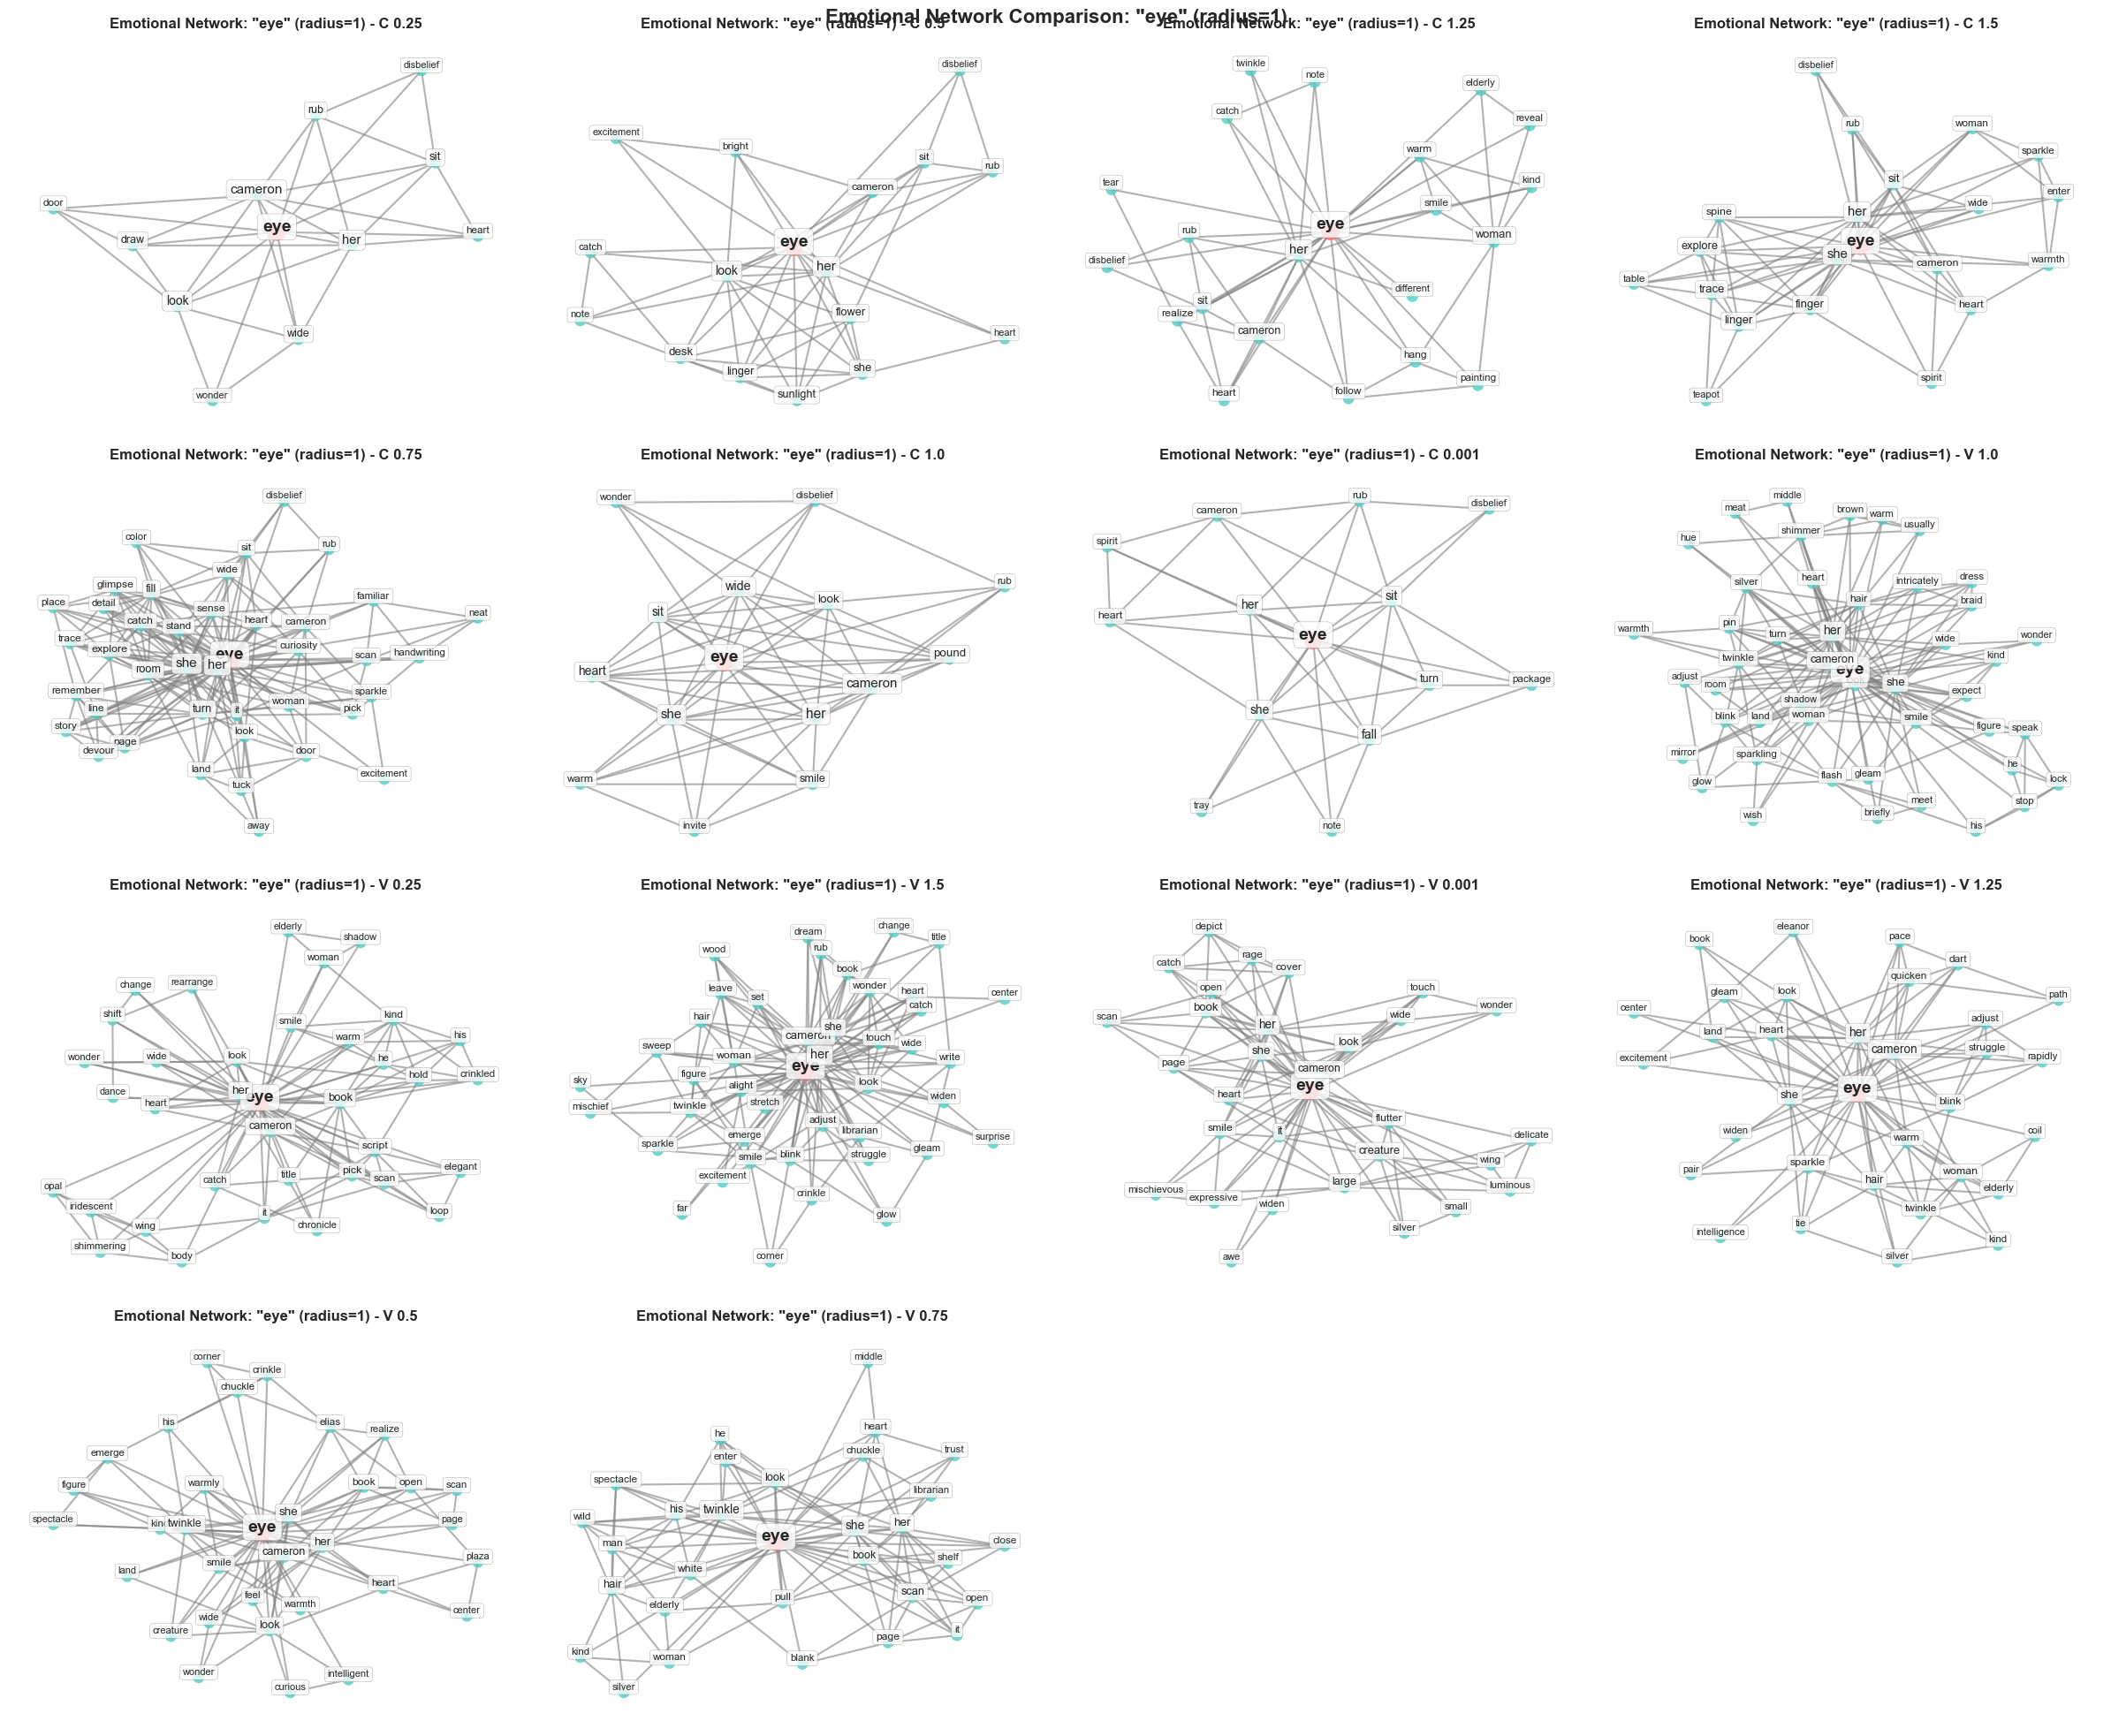

In [29]:
# Configuration for EmoAtlas semantic neighborhood visualization
import warnings
import re
import os
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns

warnings.filterwarnings("ignore", category=FutureWarning)
sns.set_style("whitegrid")

# Utility functions for EmoAtlas visualization

def clean_name(raw: str) -> str:
    """Returns a compact name for the graph."""
    name = re.sub(r'^emo_edge_list_', '', raw)
    name = name.replace('complex', 'C').replace('vague', 'V')
    return name.replace('_', ' ').strip()


def load_emoatlas_graph(file_path: str) -> nx.Graph:
    """Loads an undirected graph from an EmoAtlas edge list file."""
    G = nx.Graph()
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            for line in f:
                parts = line.strip().split('\t')  # EmoAtlas uses tab separation
                if len(parts) >= 2:
                    G.add_edge(parts[0], parts[1])
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
    return G


def visualize_emoatlas_neighborhood(G: nx.Graph, word: str, radius: int = 1,
                                   layout: str = 'spring', ax=None,
                                   title_suffix: str = '',
                                   k: float = 0.5) -> bool:
    """
    Visualizes the emotional neighborhood around a word using EmoAtlas data.
    
    Args:
        G: NetworkX graph from EmoAtlas
        word: Central word
        radius: Maximum radius from central node
        layout: Layout algorithm
        ax: Matplotlib axes
        title_suffix: Suffix for title
        k: Spring layout parameter
        
    Returns:
        bool: True if visualization was successful
    """
    if ax is None:
        plt.figure(figsize=(10, 8))
        ax = plt.gca()

    if word not in G:
        ax.text(0.5, 0.5, f'Word "{word}" not found in emotional network.', 
                ha='center', va='center', fontsize=12)
        ax.set_title(f'Word not found - {clean_name(title_suffix)}')
        ax.axis('off')
        return False

    # Extract ego subgraph
    sub = nx.ego_graph(G, word, radius=radius)
    
    if len(sub) == 0:
        ax.text(0.5, 0.5, f'No emotional connections found for "{word}".', 
                ha='center', va='center', fontsize=12)
        ax.set_title(f'No connections - {clean_name(title_suffix)}')
        ax.axis('off')
        return False

    # Layout selection
    layout_funcs = {
        'spring': lambda g: nx.spring_layout(g, seed=42, k=k),
        'circular': nx.circular_layout,
        'kamada_kawai': nx.kamada_kawai_layout,
        'spectral': nx.spectral_layout
    }
    pos = layout_funcs.get(layout, nx.spring_layout)(sub)

    # Add slight jitter to avoid overlaps
    pos = {n: (x + np.random.normal(0, 0.02), y + np.random.normal(0, 0.02))
           for n, (x, y) in pos.items()}

    # Draw edges with curved style
    nx.draw_networkx_edges(sub, pos, ax=ax,
                           connectionstyle='arc3,rad=0.1', 
                           alpha=0.6, edge_color='gray', width=1.5)

    # Draw nodes with central word highlighted
    node_colors = ['#FF6B6B' if n == word else '#4ECDC4' for n in sub]
    node_sizes = [200 if n == word else 80 for n in sub]
    
    nx.draw_networkx_nodes(sub, pos, ax=ax,
                           node_color=node_colors, 
                           node_size=node_sizes,
                           alpha=0.8)

    # Calculate font sizes based on degree centrality
    centrality = nx.degree_centrality(sub)
    min_c, max_c = min(centrality.values()), max(centrality.values())
    
    # Add labels with improved readability
    bbox = dict(boxstyle='round,pad=0.3', fc='white', ec='gray', alpha=0.8)
    for n, (x, y) in pos.items():
        font_size = 14 if n == word else 8 + 4 * (centrality[n] - min_c) / (max_c - min_c or 1)
        ax.text(x, y + 0.03, n, fontsize=font_size, ha='center', va='center', 
                bbox=bbox, weight='bold' if n == word else 'normal')

    # Enhanced title
    title = f'Emotional Network: "{word}" (radius={radius}) - {clean_name(title_suffix)}'
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.axis('off')
    return True


def get_common_emotional_words(graphs: dict, top_n: int = 15) -> list:
    """
    Returns common words across all EmoAtlas graphs, ordered by emotional connectivity.
    """
    if not graphs:
        return []
    
    # Find intersection of all node sets
    node_sets = [set(data['graph'].nodes()) for data in graphs.values()]
    common = set.intersection(*node_sets) if node_sets else set()
    
    if not common:
        return []

    # Calculate average degree across all graphs
    scores = {}
    for w in common:
        total_degree = sum(data['graph'].degree(w) for data in graphs.values())
        scores[w] = total_degree / len(graphs)

    # Return top words by emotional connectivity
    return [w for w, _ in sorted(scores.items(), key=lambda x: x[1], reverse=True)[:top_n]]


def load_emoatlas_networks() -> dict:
    """
    Loads all EmoAtlas networks from the emo_edges directories.
    Returns: {name: {'graph': G, 'path': file_path, 'type': prompt_type, 'temp': temperature}}
    """
    graphs = {}
    
    # EmoAtlas specific directories
    emo_dirs = ['emo_edges_complex', 'emo_edges_vague']
    
    for d in emo_dirs:
        if not os.path.isdir(d):
            continue
            
        prompt_type = 'complex' if 'complex' in d else 'vague'
        
        for fn in os.listdir(d):
            if fn.endswith('.txt'):
                path = os.path.join(d, fn)
                
                # Extract temperature from filename
                temp_match = re.search(r'_(\d+(?:\.\d+)?)\.txt$', fn)
                temperature = float(temp_match.group(1)) if temp_match else None
                
                try:
                    G = load_emoatlas_graph(path)
                    if G.number_of_nodes() > 0:  # Only include non-empty graphs
                        name = os.path.splitext(fn)[0]
                        graphs[name] = {
                            'graph': G, 
                            'path': path,
                            'type': prompt_type,
                            'temp': temperature
                        }
                except Exception as e:
                    print(f'Error loading {path}: {e}')
    
    return graphs


def main():
    """
    Main function for EmoAtlas semantic neighborhood analysis.
    Simplified interface focusing on comparative analysis.
    """
    print("\n=== EMOATLAS SEMANTIC NETWORK ANALYSIS ===\n")
    
    # Load EmoAtlas networks
    print("Loading EmoAtlas networks...")
    graphs = load_emoatlas_networks()
    
    if not graphs:
        print('No EmoAtlas networks found in emo_edges_* directories.')
        return
    
    print(f"Loaded {len(graphs)} EmoAtlas networks")
    
    # Show available networks grouped by type
    complex_nets = [name for name, data in graphs.items() if data['type'] == 'complex']
    vague_nets = [name for name, data in graphs.items() if data['type'] == 'vague']
    
    print(f"\nComplex prompt networks: {len(complex_nets)}")
    print(f"Vague prompt networks: {len(vague_nets)}")
    
    # Find common emotional words
    common_words = get_common_emotional_words(graphs)
    if common_words:
        print(f"\nMost connected emotional words: {', '.join(common_words[:10])}")
    
    # Simplified menu - only the most useful options
    print("\nAnalysis Options:")
    print("1) Compare word across all networks (comprehensive view)")
    print("2) Compare word across prompt types (Complex vs Vague)")
    print("3) Exit")
    
    choice = input('\nChoice: ').strip()
    
    if choice == '1':
        # Compare across all networks
        word = input('Word to compare: ').strip()
        radius = int(input('Radius (default 1): ').strip() or 1)
        layout = input('Layout (default spring): ').strip() or 'spring'
        k = float(input('Spring parameter k (default 0.5): ').strip() or 0.5)
        
        # Create grid layout
        n = len(graphs)
        rows = int(np.ceil(np.sqrt(n)))
        cols = int(np.ceil(n / rows))
        
        fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 5))
        axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]
        
        success_count = 0
        for i, (name, data) in enumerate(graphs.items()):
            if visualize_emoatlas_neighborhood(data['graph'], word, radius, layout,
                                              ax=axes[i], title_suffix=name, k=k):
                success_count += 1
        
        # Hide unused subplots
        for j in range(len(graphs), len(axes)):
            axes[j].axis('off')
        
        if success_count > 0:
            plt.suptitle(f'Emotional Network Comparison: "{word}" (radius={radius})', 
                        fontsize=16, fontweight='bold')
            plt.tight_layout()
            plt.show()
        else:
            print(f'Word "{word}" not found in any network.')
    
    elif choice == '2':
        # Compare across prompt types (most important for your research)
        word = input('Word to compare: ').strip()
        radius = int(input('Radius (default 1): ').strip() or 1)
        layout = input('Layout (default spring): ').strip() or 'spring'
        k = float(input('Spring parameter k (default 0.5): ').strip() or 0.5)
        
        # Group by prompt type
        complex_graphs = {name: data for name, data in graphs.items() if data['type'] == 'complex'}
        vague_graphs = {name: data for name, data in graphs.items() if data['type'] == 'vague'}
        
        fig, axes = plt.subplots(1, 2, figsize=(16, 8))
        
        # Visualize one representative from each type (e.g., temperature 0.5)
        for graphs_dict, ax, title in [(complex_graphs, axes[0], 'Complex Prompt'),
                                       (vague_graphs, axes[1], 'Vague Prompt')]:
            # Find network closest to temperature 0.5
            best_net = min(graphs_dict.items(), 
                          key=lambda x: abs(x[1]['temp'] - 0.5) if x[1]['temp'] is not None else float('inf'))
            
            if visualize_emoatlas_neighborhood(best_net[1]['graph'], word, radius, layout,
                                              ax=ax, title_suffix=f"{title} (T={best_net[1]['temp']})", k=k):
                pass
        
        plt.suptitle(f'Emotional Networks: "{word}" - Complex vs Vague Prompts', 
                    fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
    
    else:
        print('Exit.')


if __name__ == '__main__':
    main()